# Learning to play Blackjack with Monte Carlo methods

https://en.wikipedia.org/wiki/Blackjack

## Setting up the environment

In [2]:
import gym
import numpy as np
from collections import defaultdict
from plots_blackjack import plot_values, plot_policy

In [3]:
env = gym.make('Blackjack-v0') # create blackjack environment

In [4]:
env.action_space # number of actions available (0 "stay" or 1 "hit")

Discrete(2)

In [5]:
env.observation_space # the state pace is comprised of (total_player, visible_card_dealer, Whether or not I have an Ace)
                      # total player is in the range [0 - 31]
                      # visible_card_dealer in range [0 - 10]
                      # Whether or not I have an ace: True/False

Tuple(Discrete(32), Discrete(11), Discrete(2))

## example usage

In [6]:
env.reset() #reset the environment, get the first state

(11, 4, False)

In [7]:
action = 0 # stay
env.step(action) # returns ((current state), reward, game_over?) 

((11, 4, False), 1.0, True, {})

In [8]:
env._get_obs() # return the current state of the game

(11, 4, False)

In [9]:
def run_policy(env):
    
    state = env.reset()
    print("total of player: {0}, dealer card showing: {1}, Do I have and Ace: {2}".format(state[0], state[1], state[2]))

    total_reward = 0
    num_steps = 0
    while True:
        
        # take random action
        action = env.action_space.sample()
        # transition
        next_state, reward, is_terminal, _ = env.step(action)
        print("\nTake action: {0}".format(action) )
        print("total of player: {0}, dealer card showing: {1}, Do I have and Ace: {2}".format(next_state[0], next_state[1], next_state[2]))
        print("reward: {0}, done:{1}".format(reward, is_terminal))

        total_reward += reward
        num_steps += 1

        if is_terminal:
            break
        
    return total_reward, num_steps

In [10]:
run_policy(env)

total of player: 14, dealer card showing: 8, Do I have and Ace: False

Take action: 0
total of player: 14, dealer card showing: 8, Do I have and Ace: False
reward: -1.0, done:True


(-1.0, 1)

In [11]:
player_state_space = 32
dealer_state_space = 11
ace_state_space = 2
action_space = 2
actions = [0,1]

create a policy that maps states to actions S -> A. Here our state is actually represented as the tuple 
(player score, dealer score, usable ace) and our actions are {0,1}

To do this in we can have a policy that assigns to each state a probability of chosing either 0 or 1. i.e.

P(0| player_score, dealer_score, ace_available) and P(1| player_score, dealer_score, ace_available)

this can be stored in a 4d array with the first axis being the player_score (0 - 21) second is the dealer_score( 0 - 11) the third being ace_available( 0,1 ) and finally the final one is hit or stay (0 , 1 ).

In [12]:
def generate_episode(policy):
    '''
    Function to generate an episode following a policy. Policy is of the form {state:[prob_stay, prob_hit], ...}
    '''
    
    episode = [] # store the episode
    player_score, dealer_card, ace = env.reset() # start the game
    state = (player_score, dealer_card, ace) # state state
    
    while True:
        # get action
        action = np.random.choice(actions, 1, p = policy[state])[0]
        
        # take action in environement
        next_state, reward, done, info = env.step(action)

        # append outcome
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            break
    
    return episode

In [13]:
def generate_episodes(policy, num_episodes):
    episodes = []

    counter = 0
    while counter < num_episodes:
        episodes.append(generate_episode(policy))
        counter +=1
        
    return episodes

In [14]:
rand_policy = dict()

for p in range(player_state_space):
    for d in range(dealer_state_space):
        for ace in [True, False]:
            
            state = (p,d,ace)
            # chose any action with equal probability
            rand_policy[state] = [0.5 , 0.5]
            

In [15]:
# policy to stay if we get anything above 18
naive_policy = dict()

for p in range(player_state_space):
    for d in range(dealer_state_space):
        for ace in [True, False]:
            
            state = (p,d,ace)
            if p >= 18:
                naive_policy[state] = [0.9, 0.1] # stay
                
            else:
                naive_policy[state] = [0.1, 0.9] # hit

In [16]:
# example of generating a random episode
generate_episode(rand_policy)

[((19, 6, True), 0, 1.0)]

In [17]:
# example of generating an episode following a naive policy
generate_episode(naive_policy)

[((14, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]

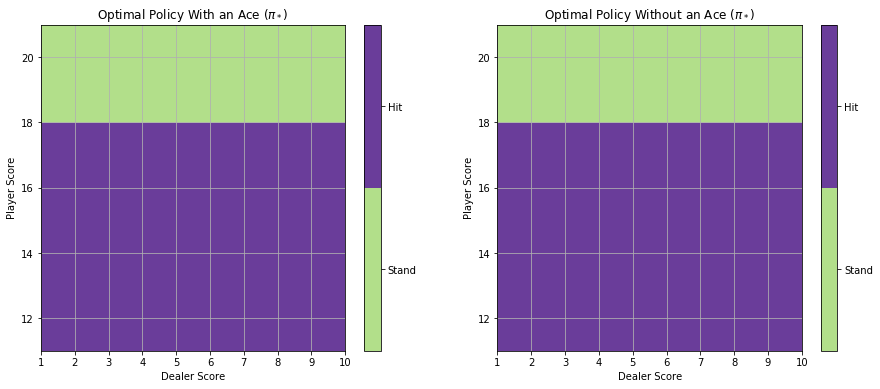

In [18]:
# visualizing the policy
plot_policy(naive_policy)

In [ ]:
# generate multiple episodes
episodes = generate_episodes(naive_policy, 10000)

In [ ]:
episodes[:10]

## Monte Carlo Estimation

In [19]:
def get_return(episode, discount = 1.0):
    '''
    Function to get the discounted return of an episode
    '''
    
    total = 0
    index = 0

    for step in episode:
        state, action, reward = step
        total += (discount ** index) * reward
        index += 1

    return total

In [20]:
def mc_estimation(episodes, discount = 1.0):
    '''
    Implementation of first visit Monte Carlo estimation 
    '''
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for episode in episodes:
        
        visited_states = []
        index = 0
        
        for step in episode:
            
            state, action, reward = step
            
            if (state not in visited_states):
                
                visited_states.append(state)
                r = get_return(episode[index:], discount = discount)
                returns_sum[state][action] += r
                N[state][action] += 1.0
                Q[state][action] = returns_sum[state][action] / N[state][action]
                
            index += 1
            
    return Q

In [28]:
naive_episodes = generate_episodes(naive_policy, 100000)
rand_episodes = generate_episodes(rand_policy, 100000)

naive_Q = mc_estimation(naive_episodes)
rand_Q = mc_estimation(rand_episodes)

In [29]:
def Q_to_V(Q, policy):
    '''
    Function to change Q values into V values
    '''
    v={}
    for state, value in Q.items():
        
        p_stay = policy[ state ][0]
        p_hit = p = policy[ state ][1]
        
        v[state] = p_stay * value[0] + p_hit * value[1]
        
    
    return v

In [30]:
naive_v = Q_to_V(naive_Q, naive_policy)
rand_v = Q_to_V(rand_Q, rand_policy)

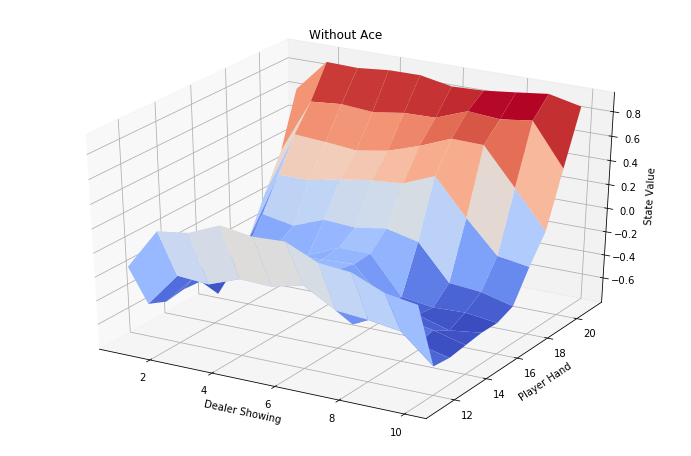

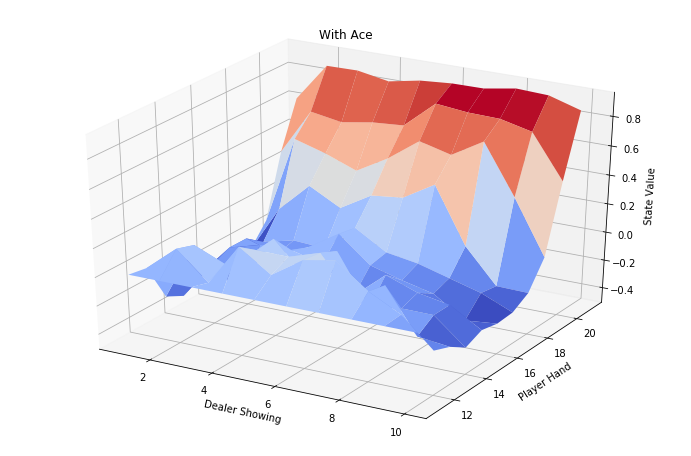

In [31]:
from plots_blackjack import plot_values, plot_policy
plot_values(naive_v)

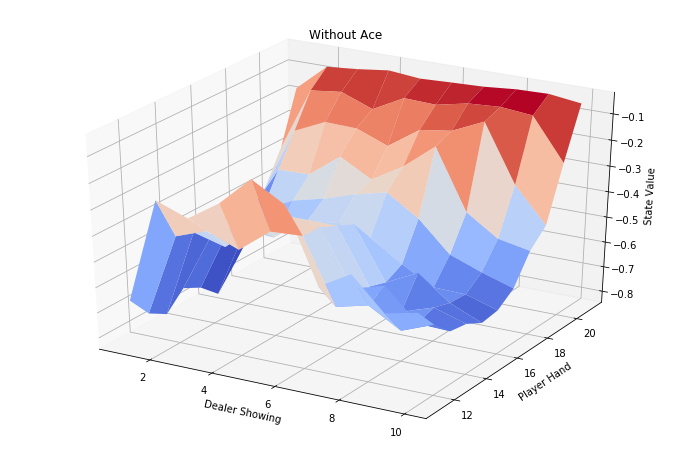

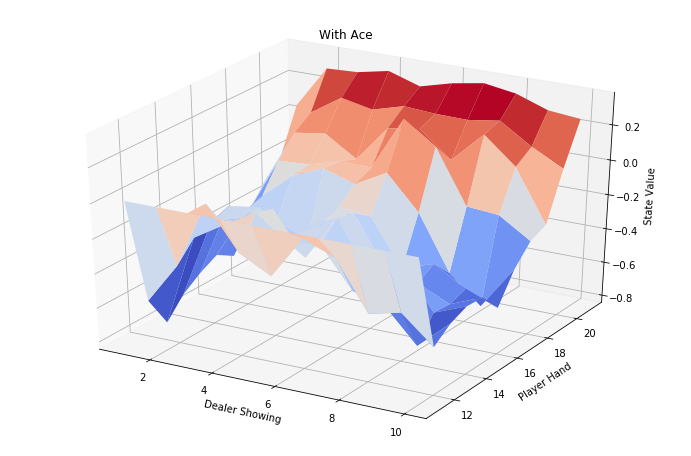

In [32]:
plot_values(rand_v)

# Monte Carlo Control

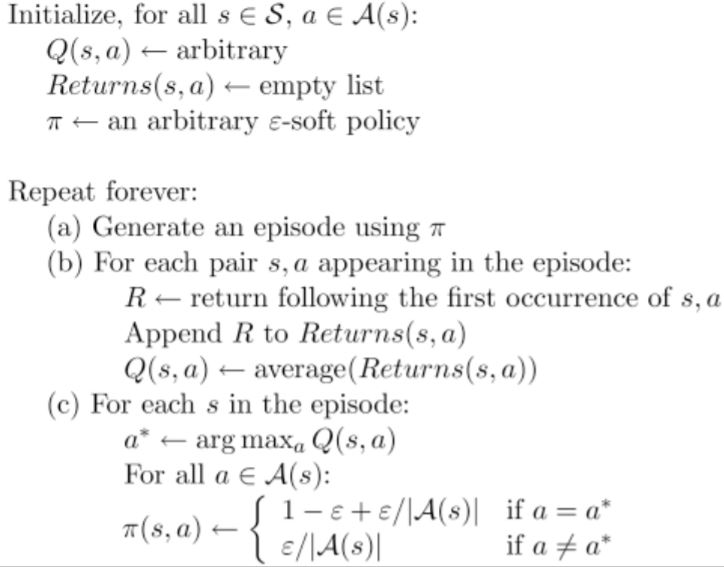

In [24]:
def mc_control(policy, epsilon, number_iterations, discount = 1.0):
    
    new_policy = policy.copy()
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    
    counter = 0
    distance = 0
    while counter < number_iterations:
        counter +=1
        
        # create decaying learning rate 
        if counter == distance + (number_iterations-distance)/2: 
            epsilon = epsilon/2
            distance = counter
            
        episode = generate_episode(new_policy)
        visited_states = []
        index = 0

        for step in episode:

            state, action, reward = step

            if (state not in visited_states):

                visited_states.append(state)
                r = get_return(episode[index:],discount = discount)
                returns_sum[state][action] += r
                N[state][action] += 1.0
                Q[state][action] = returns_sum[state][action] / N[state][action]
        
        for state in visited_states:
            
            a_star = np.argmax(Q[state])
            a_other = 1 - a_star

            # update policy
            new_policy[state][a_star] = 1 - epsilon + epsilon/2
            new_policy[state][a_other] = epsilon/2


            index += 1
            
    return Q, new_policy

In [25]:
new_Q, new_policy = mc_control(naive_policy, epsilon = 0.8, number_iterations = 500000)

In [26]:
print(new_policy[(13, 2, True)])

[0.0125, 0.9874999999999999]


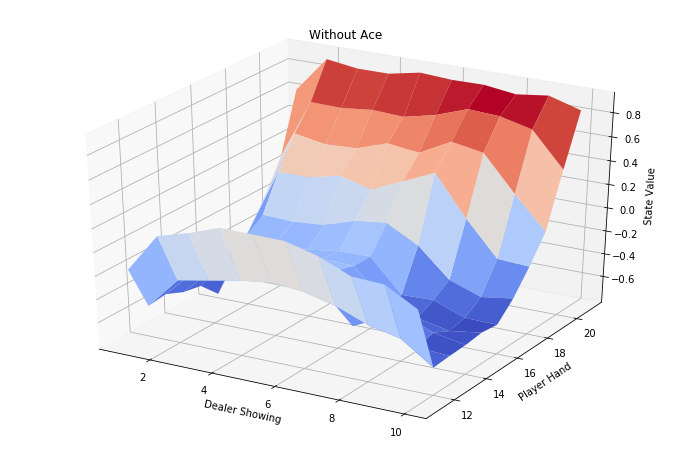

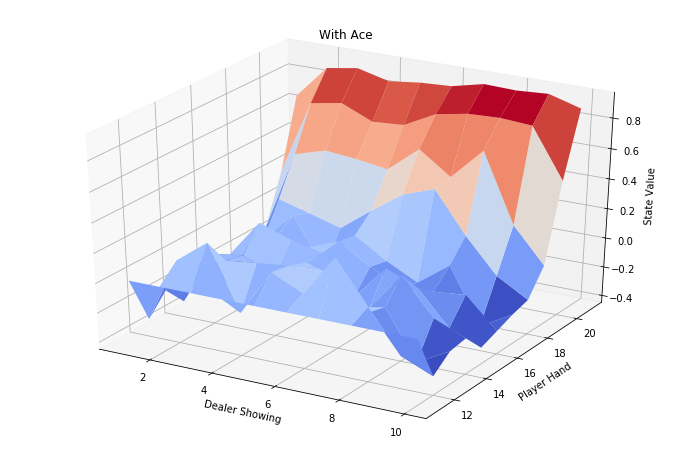

In [27]:
# Generate new episodes
opt_episodes = generate_episodes(new_policy, 100000)

opt_Q = mc_estimation(opt_episodes)
opt_V = Q_to_V(opt_Q, new_policy)

plot_values(opt_V)

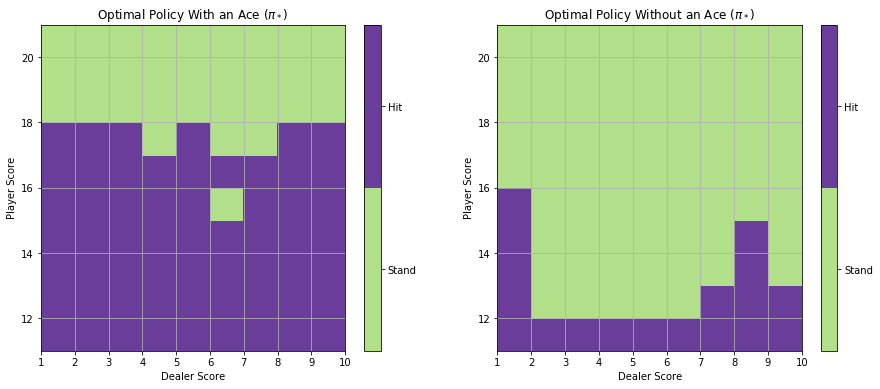

In [33]:
plot_policy(new_policy)

In [34]:
def average_return(episodes):
    
    returns = []
    for episode in episodes:
        
        r = get_return(episode)
        returns.append(r)
    
    returns = np.array(returns)
        
    return np.mean(returns), np.std(returns)

In [35]:
print(average_return(naive_episodes))
print(average_return(opt_episodes))
print(average_return(rand_episodes))

(-0.07859, 0.9584641943755645)
(-0.08311, 0.9579680202908655)
(-0.39577, 0.8949056414505385)
